In [2]:
# initialise relevant packages
import pandas as pd
import csv
import numpy as np
import re
import operator
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import fasttext

from sys import getsizeof
from collections import Counter, defaultdict
from sklearn.feature_extraction import stop_words
from html import unescape


# define plot style
plt.style.use('seaborn')

# font sizes
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

/Users/Paul/opt/miniconda3/envs/language_change/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


## Load Unlabelled Gab Corpus

In [4]:
%%time

# load texts from unlabelled corpus into set

# initialise empty lists --> faster than appending to dict
texts = []
dates = []

# initialise counter var for counting iterations
counter = 0

sample_freq = 100 # sample every n-th post with n = sample_freq
print_freq = 1000000 # print progress every n posts with n = print_freq

# iterate over each line
with open('./0_data/gabposts_clean_170221.csv', 'r') as read_obj:
    csv_dict_reader = csv.DictReader(x.replace('\0', '') for x in read_obj)
    for row in csv_dict_reader:
        if counter % sample_freq == 0:
            texts.append(row['text'])
            dates.append(row['created_at'])
        counter+=1
        if counter % print_freq == 0:
            print(counter)

# create dataframe from lists
texts = pd.Series(texts, name = 'text')
dates = pd.Series(dates, name = 'created_at')
sample_df = pd.concat([texts, dates], axis=1)

# clear out RAM
del texts
del dates

# convert dtypes
sample_df['created_at']= sample_df.created_at.astype('datetime64')
sample_df['text']= sample_df.text.astype('string')

# print finished df
sample_df

1000000
2000000
3000000
4000000
5000000
6000000
7000000
8000000
9000000
10000000
11000000
12000000
13000000
14000000
15000000
16000000
17000000
18000000
19000000
20000000
21000000
22000000
23000000
24000000
25000000
26000000
27000000
28000000
29000000
30000000
31000000
32000000
33000000
34000000
CPU times: user 2min 53s, sys: 4.73 s, total: 2min 57s
Wall time: 2min 59s


,text,created_at
0,Hello world!,2016-08-10 06:58:37
1,@The_Caveman appreciate that! Was thinking ver...,2016-08-15 02:42:23
2,"@magafeed Psyched to be here, fellow MAGApedes!",2016-08-16 01:54:57
3,@Darian_Wolf @mm ass adventurer,2016-08-16 03:41:58
4,Alright first night on @gab loving it so far. ...,2016-08-16 05:45:53
...,...,...
342328,It's probably cause I don't like the taste of ...,2018-10-29 02:54:08
342329,And I've offered.,2018-10-29 02:55:43
342330,#IStandWithGAB,2018-10-29 02:57:04
342331,"Hey you need to name these people, so everybod...",2018-10-29 02:58:35


## Set Time Slice Span
Time span: 08/16 to 10/18 --> 27 months in total

In [5]:
# set time span for slices
n_months = 1

## Posts per Month

In [6]:
# count posts per month
post_counts = sample_df.groupby(sample_df.created_at.apply(lambda x: x.to_period('M'))).text.count().reset_index()

# collapse into slices of n_month length
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=n_months) # forward-looking window
post_counts[f'n_posts_{n_months}m'] = post_counts['text'].rolling(window=indexer).sum()

post_counts.drop(index=[i for i in list(post_counts.index) if i%n_months!=0], inplace=True, errors = 'ignore') # drop redundant rows
post_counts.drop(columns='text', inplace=True, errors = 'ignore') # drop redundant column

post_counts

,created_at,n_posts_1m
0,2016-08,886.0
1,2016-09,3226.0
2,2016-10,4746.0
3,2016-11,7164.0
4,2016-12,9339.0
5,2017-01,9029.0
6,2017-02,7677.0
7,2017-03,7269.0
8,2017-04,6065.0
9,2017-05,7272.0


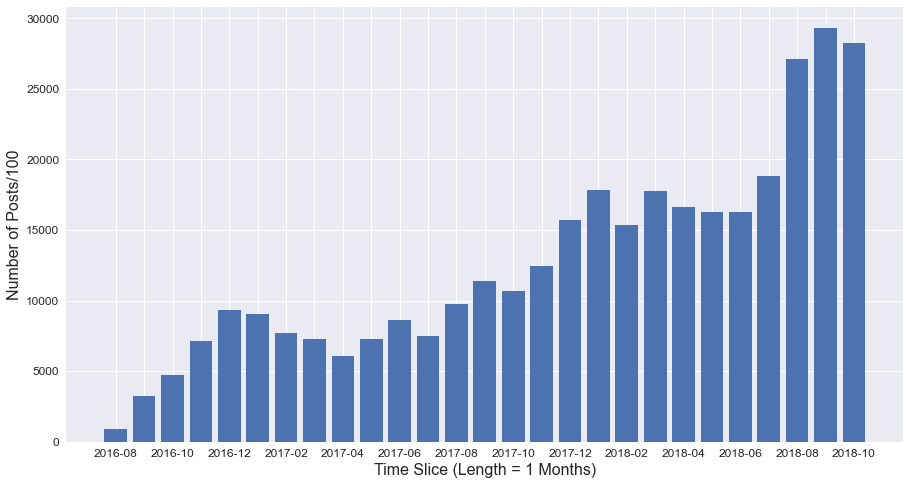

In [13]:
# plot number of posts per window

# Create list of time slices
time_slices = pd.unique(text_df.time_slice)

x = np.arange(0,len(post_counts),1)
fig, ax = plt.subplots(1,1, figsize=(15,8))

ax.bar(time_slices, post_counts[f'n_posts_{n_months}m'])
ax.set_xticks(x+1)
ax.set_xticklabels(post_counts.created_at)
plt.xlabel(f'Time Slice (Length = {n_months} Months)')
plt.ylabel(f'Number of Posts/{sample_freq}')
for label in ax.xaxis.get_ticklabels()[1::2]:
    label.set_visible(False)
plt.show()

## Drop Non-English Language Posts

In [9]:
# create copy of sample_df to avoid having to reload sample_df
text_df = sample_df.copy()

In [11]:
%%time

fmodel = fasttext.load_model('./0_models/lang_detect/lid.176.bin')

def check_language(text):
    predictions = fmodel.predict(text, k=3)
    
    # if top prediction is certain and not English, return non-English
    if (predictions[0][0]!='__label__en') and (predictions[1][0]>0.80):
        return 'non-English'
    
    # else if English is one of top 3 predictions, return English
    elif '__label__en' in predictions[0]:
        return 'English'
    
    # else return non-English
    else:
        return 'non-English'

# save number of documents before dropping non-English posts
n_docs = text_df.shape[0]

# drop non-English posts
text_df = text_df[text_df.text.apply(lambda x: check_language(x) == 'English')]

print(f'{n_docs} posts, of which {n_docs - text_df.shape[0]} were dropped for (most likely) not being in English.')
print(f'{text_df.shape[0]} posts remain. \n')

342333 posts, of which 20230 were dropped for (most likely) not being in English.
322103 posts remain. 

CPU times: user 13.6 s, sys: 196 ms, total: 13.8 s
Wall time: 14.1 s


## Label Texts with Time Slice Index

In [12]:
%%time 

# write time_slice index as df column

# create column with year-month from created_at datetime
text_df['year_month'] = text_df.created_at.apply(lambda x: x.to_period('M'))

compare_month = text_df.loc[0].year_month
time_slice = 1
slice_list = []

for index, row in text_df.iterrows():
    if row.year_month == compare_month + n_months:
        time_slice += 1
        compare_month = row.year_month
    slice_list.append(time_slice)

slice_list = pd.Series(slice_list)
slice_list.name = 'time_slice'

# concat series with time slices indeces to df
text_df = pd.concat([text_df.reset_index(drop=True), slice_list.reset_index(drop=True)], axis=1)


# create dict for slice index --> month mapping
time_slices = pd.unique(slice_list)
year_months = pd.unique(text_df['year_month']).map(str)

time_dict = dict()
for t in time_slices:
    time_dict[t] = year_months[t*n_months-1]

CPU times: user 37.2 s, sys: 203 ms, total: 37.4 s
Wall time: 37.4 s


## Clean Text

In [14]:
%%time

# Define function to clean text
def clean(text):

    # replace mentions and URLs with special token
    text = re.sub(r"@[A-Za-z0-9_-]+",'[USER]',text)
    text = re.sub(r"http\S+",'[URL]',text)
    
    # convert html
    text = unescape(text)
    
    # retain only letters
    text = re.sub('[^a-zA-Z]', ' ', text)
    
    text = ' '.join([w.lower() for w in text.split()])
    
    return text

# create clean_text column
text_df['clean_text'] = text_df.text.apply(clean)

CPU times: user 4.76 s, sys: 39.9 ms, total: 4.8 s
Wall time: 4.81 s


## Vocab Counts Per Time Slice

In [18]:
# import stop words
stops = list(stop_words.ENGLISH_STOP_WORDS)

# Add 't', 's', 'url', 'user' to list of stopwords (effect of cleaning function)
stops = stops + ['t', 's', 'url', 'user', 'o', 'just', 'like', 'm', 'll', 've',
                 'don', 'good', 'people', 'right', 'think', 'know', 'time', 'want', 'did', 'lol', 'need', 'going']

print('Number of words in stopwords list:', len(stops))
print('10 words on the stopwords list:', stops[:10])

Number of words in stopwords list: 340
10 words on the stopwords list: ['such', 'yet', 'amoungst', 'sixty', 'top', 'down', 'being', 'several', 'ten', 'whoever']


In [19]:
# Define function to create dictionary with vocab counts
def create_dict(slice_texts):
    # Create a list of all words in the time slice
    word_list = [w for r in slice_texts for w in r.strip().split()]
    # Create a dictionary of words and corresponding frequency counts using a Counter
    vocab_dict = Counter(word_list)
    # Return filtered dictionary
    return Counter({w: c for w, c in vocab_dict.items() if not w in stops})

In [20]:
%%time

# Initialize dictionary for storing vocabularies
vocab_dicts = dict()

# Loop over time slices and create vocabularies
for t in time_slices:
    vocab_dicts[t] = create_dict(text_df[text_df.time_slice==t].clean_text)
    
# Loop over time slices and create vocabularies NOT IN TIME SLICE
for t in time_slices:
    vocab_dicts[f"not_{t}"] = create_dict(text_df[text_df.time_slice!=t].clean_text)
    
# Create vocab_dict for entire corpus
vocab_dicts['total'] = create_dict(text_df.clean_text)

CPU times: user 1min 9s, sys: 1.89 s, total: 1min 11s
Wall time: 1min 11s


In [24]:
# Inspect vocabularies for each time slice 
for t in time_slices:
    print(f'T{t} - {time_dict[t]}')
    print(f'Number of unique words: {len(vocab_dicts[t])}')
    print(f'Most frequent words: {vocab_dicts[t].most_common(15)} \n')

T1 - 2016-08
Number of unique words: 3305
Most frequent words: [('gab', 68), ('trump', 39), ('hillary', 27), ('maga', 25), ('gabfam', 25), ('post', 23), ('say', 23), ('great', 23), ('make', 23), ('really', 21), ('got', 19), ('shit', 19), ('best', 19), ('yes', 19), ('love', 19)] 

T2 - 2016-09
Number of unique words: 8474
Most frequent words: [('trump', 212), ('gab', 203), ('hillary', 178), ('gabfam', 178), ('maga', 130), ('really', 83), ('great', 76), ('d', 76), ('love', 75), ('speakfreely', 67), ('make', 64), ('new', 64), ('let', 63), ('say', 61), ('welcome', 61)] 

T3 - 2016-10
Number of unique words: 11244
Most frequent words: [('trump', 576), ('maga', 448), ('hillary', 403), ('gabfam', 199), ('gab', 196), ('clinton', 148), ('news', 136), ('speakfreely', 122), ('really', 122), ('presidentialdebates', 111), ('new', 109), ('way', 108), ('d', 106), ('got', 106), ('make', 103)] 

T4 - 2016-11
Number of unique words: 13833
Most frequent words: [('trump', 843), ('maga', 646), ('gab', 330)

## Vocab Weirdness Per Time Slice

In [32]:
%%time 

# weirdness = (count(word) in t/count(all words) in t)/(count(word) in not_t/count_all)
# added 1 to numerator and denominator to avoid division by zero

weirdness_dicts = dict()

for t in time_slices:
    
    n_words_t = sum(vocab_dicts[t].values())
    n_words_not_t = sum(vocab_dicts[f'not_{t}'].values())
    
    weirdness_dicts[t] = Counter()
    
    # iterate through words in each time slice that occured at least twice
    for word in {x: count for x, count in vocab_dicts[t].items() if count >= 2}.keys():
        
        prop_word_t = vocab_dicts[t][word]/n_words_t
        prop_word_not_t = vocab_dicts[f'not_{t}'][word]/n_words_not_t
        
        weirdness_dicts[t][word] = (prop_word_t+1)/(prop_word_not_t+1)

CPU times: user 926 ms, sys: 1.11 s, total: 2.03 s
Wall time: 3.19 s


In [34]:
# Inspect "weirdest" words for each time slice 
print('TOP 10 "WEIRDEST" WORDS PER TIME SLICE: \n')
for t in time_slices:
    print(f'T{t} - {time_dict[t]}')
    print(f'{[k for k, v in weirdness_dicts[t].most_common(15)]} \n')

TOP 10 "WEIRDEST" WORDS PER TIME SLICE: 

T1 - 2016-08
['gab', 'hillary', 'ohcarl', 'post', 'clinton', 'best', 'gabfam', 'welcome', 'great', 'speakfreely', 'actually', 'yes', 'say', 'shit', 'really'] 

T2 - 2016-09
['hillary', 'gab', 'gabfam', 'maga', 'introduceyourself', 'welcome', 'speakfreely', 'clinton', 'trump', 'really', 'followers', 'love', 'hillaryshealth', 'questions', 'great'] 

T3 - 2016-10
['hillary', 'maga', 'trump', 'gabfam', 'clinton', 'presidentialdebates', 'wikileaks', 'gab', 'speakfreely', 'draintheswamp', 'really', 'election', 'debate', 'vote', 'voting'] 

T4 - 2016-11
['maga', 'trump', 'gabfam', 'hillary', 'draintheswamp', 'speakfreely', 'gab', 'presidenttrump', 'pizzagate', 'twitter', 'election', 'welcome', 'clinton', 'news', 'media'] 

T5 - 2016-12
['maga', 'gabfam', 'trump', 'speakfreely', 'pizzagate', 'news', 'obama', 'christmas', 'draintheswamp', 'fakenews', 'presidenttrump', 'gab', 'merry', 'recount', 'election'] 

T6 - 2017-01
['trump', 'maga', 'gabfam', 'spe

## Vocab Deviation from Avg. Frequency Per Time Slice

In [36]:
%%time

# calculate % frequency of words across entire corpus

# sum of number of tokens in total corpus
n_words_total = sum(vocab_dicts['total'].values())

avg_freq = Counter()

# iterate through words in total that occured at least min_freq times
for word in {x: count for x, count in vocab_dicts['total'].items()}.keys():
    # calculate average frequency of words across all time slices
    avg_freq[word] = vocab_dicts['total'][word]/n_words_total

CPU times: user 244 ms, sys: 830 ms, total: 1.07 s
Wall time: 2.03 s


In [37]:
%%time

# calculate % frequency of words in each time slice and return as multiple of % frequency across entire corpus

rel_freq_dicts = dict()

for t in time_slices:
    n_words_t = sum(vocab_dicts[t].values())
    
    rel_freq_dicts[t] = Counter()
    
    # iterate through words in each time slice that occured at least min_freq times
    for word in {x: count for x, count in vocab_dicts[t].items()}.keys():
        
        prop_word_t = vocab_dicts[t][word]/n_words_t
        
        rel_freq_dicts[t][word] = (prop_word_t)/(avg_freq[word])

CPU times: user 725 ms, sys: 135 ms, total: 861 ms
Wall time: 871 ms


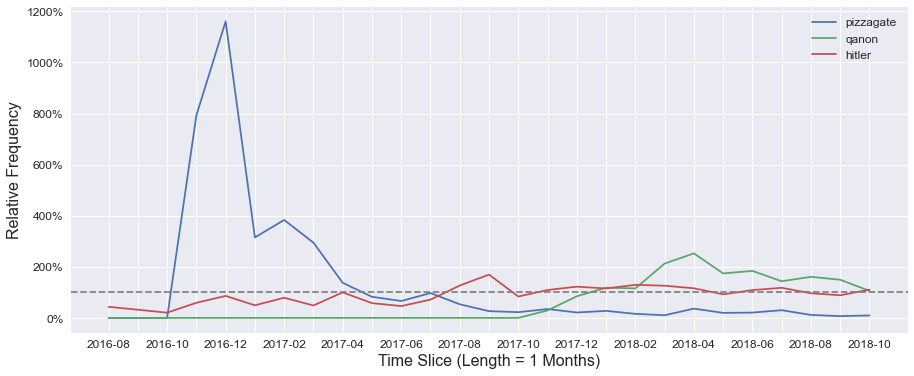

In [49]:
plot_terms = ['pizzagate', 'qanon']
#plot_terms = ['trump', 'hillary', 'election', 'gab']
#plot_terms = ['jew', 'woman', 'black', 'muslim']
#plot_terms = ['winter', 'summer']

y_values = dict()

for term in plot_terms:
    y_values[term] = []
    for t in time_slices:
        y_values[term].append(rel_freq_dicts[t][term])

plot_df = pd.DataFrame.from_dict(y_values)
plot_df.index +=1

ax = plot_df.plot(figsize=(15,6))
ax.set_xticks(time_slices)
plt.xlabel(f'Time Slice (Length = {n_months} Months)')
plt.axhline(y=1, color='gray', linestyle='--')
plt.ylabel('Relative Frequency')
ax.set_xticklabels(year_months)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
for label in ax.xaxis.get_ticklabels()[1::2]:
    label.set_visible(False)
plt.show()